# Introduction

This notebook demonstrates plotting an image on a map.

1. Find some datasets to load
2. Load pixel data in EPSG:3857 projection, same as used by most web maps
3. Display datasets footptints on a map
4. Display image loaded from these datasets on a map

### NCI Environment Setup

```bash
module load dea/20190524
pip install --user 'git+https://github.com/opendatacube/dea-proto.git#egg=odc_ui&subdirectory=libs/ui'
```

In [9]:
from IPython.display import display
import ipyleaflet as L
from ipywidgets import widgets as w
import numpy as np
import pandas as pd
import geopandas as gpd

from datacube import Datacube

from odc.ui import show_datasets, mk_image_overlay, with_ui_cbk

------------------------------------------------

In [ ]:
# def select_on_a_map(**kwargs):
#     """ Display a map and block execution until user selects a region of interest.

#     Returns selected region as datacube Geometry class.

#         polygon = select_on_map()

#     **kwargs**
#       height -- height of the map, for example "500px", "10el"

#     Any parameter ipyleaflet.Map(..) accepts:
#       zoom   Int
#       center (lat: Float, lon: Float)
#       ...
#     """
#     from IPython.display import display
#     from ._ui import ui_poll

#     m, state = mk_map_region_selector(**kwargs)
#     display(m)

#     def extract_geometry(state):
#         from datacube.utils.geometry import Geometry
#         from datacube.testutils.geom import epsg4326

#         return Geometry(state.selection, epsg4326)

#     return ui_poll(lambda: extract_geometry(state) if state.done else None)



In [3]:
import json
import sys
import numpy as np
import rasterio.features
import matplotlib.pyplot as plt
from IPython.display import display
from odc.ui import ui_poll, mk_map_region_selector
from datacube.testutils.geom import epsg3857, epsg4326
from ipyleaflet import Map, basemaps, basemap_to_tiles


def extract_geometry(state):
    from datacube.utils.geometry import Geometry
    from datacube.testutils.geom import epsg4326

    return Geometry(state.selection, epsg4326)


def extract_spectra(state, ds, name='spectra'):    
        
    geom = extract_geometry(state) 

    # Change CRS and convert to geojson
    poly_region = geom.to_crs(epsg3857)

    # Convert to mask
    poly_mask = rasterio.features.rasterize([poly_region.__geo_interface__], 
                                            out_shape=(ds.geobox.height, ds.geobox.width), 
                                            transform=ds.geobox.affine, all_touched=True)

    # Extract spectra
    spectra = (ds.where(poly_mask)
               .mean()
               .to_array()
               .to_dataframe(name=name)
               .drop('time', axis=1))   
    
    return spectra, geom    


def spectra_from_map(ds, name='spectra', i=0, clamp=3000):

    # Set up map and zoom
    m, state = mk_map_region_selector(height='500px', 
                                      center=ds.extent.to_crs(epsg4326).centroid.coords[0][::-1], 
                                      zoom=13, layers=(basemap_to_tiles(basemaps.Esri.WorldImagery),))
    
    # Create image overlay from dataset and add to map
    img_layer = mk_image_overlay(ds.isel(time=[i]), clamp=clamp, fmt='png', bands=('red', 'green', 'blue'))
    m.add_layer(img_layer)

    # Create opacity slider
    slider = w.FloatSlider(min=0, max=1, value=1,        # Opacity is valid in [0,1] range
                           orientation='vertical',       # Vertical slider is what we want
                           readout=False,                # no need to show exact value
                           layout=w.Layout(width='2em')) # Fine tune display layout, make it thinner

    # Connect slider value to opacity property of the Image Layer
    w.jslink((slider, 'value'),         
             (img_layer, 'opacity') )
    m.add_control(L.WidgetControl(widget=slider))

    # Display the map
    display(m)

    # Request polygon drawing and return spectra
    spectra, geom = ui_poll(lambda: extract_spectra(state, 
                                                    ds=ds.isel(time=i), 
                                                    name=name) if state.done else None)

    return spectra, geom


# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('/g/data/r78/rt1527/dea-notebooks/10_Scripts')
import DEAPlotting

dc = Datacube()

## Initialise list of output data

In [63]:
# Create output list
output_spectra = []

## Import data

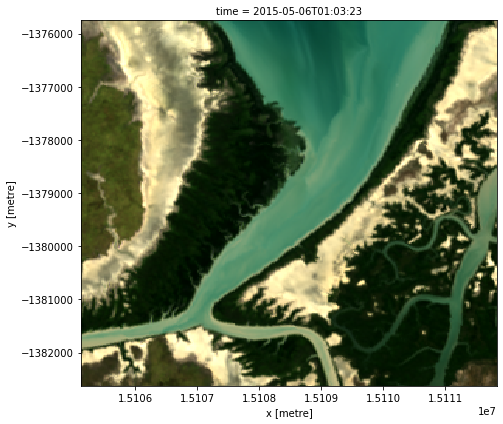

In [86]:
# # Artificial shoreline
# date = ('2015-12-13')
# lat, lon = -33.98, 151.19934

# # Tidal flats
# date = ('2016-08-01')
# lat, lon = -12.40, 130.83

# # Sandy beach
# date = ('2019-03-11')
# lat, lon = -32.78345, 152.04314

# # Rocky cliff
# date = ('2018-07-11')
# lat, lon = -15.04444, 125.17616

# Mangrove veg
date = ('2015-05-06')
lat, lon = -12.29405, 135.72184



# Set up query
query = dict(time=date,
             lat=(lat - 0.03, lat + 0.03), 
             lon=(lon - 0.03, lon + 0.03))

# Load data
ds = dc.load(product='ls8_nbart_albers',
             measurements=['blue', 'green', 'red', 'nir', 'swir1', 'swir2'],
             output_crs='EPSG:3857',  # This is what Leaflet uses by default
             group_by='solar_day',
             resolution=(-25, 25),
             resampling='cubic',
             progress_cbk=with_ui_cbk(),
             **query)

# Plot preview
DEAPlotting.rgb(ds, col='time')


## Extract spectra

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

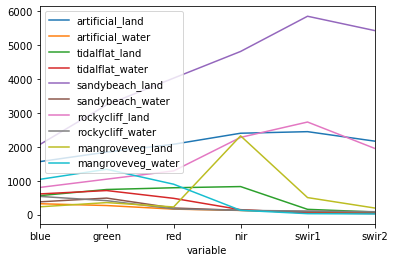

In [90]:
name='mangroveveg_water'

# Extract spectra from map
spectra, geom = spectra_from_map(ds, name=name, i=0, clamp=2000)
spectra = spectra.T
spectra.insert(0, 'lon', lon)
spectra.insert(0, 'lat', lat)
spectra.insert(0, 'date', date)
output_spectra.append(spectra.T)

# Export geometry to file
gj = geom.to_crs(epsg4326).__geo_interface__
json.dump(gj, open(f'spectra_outputs/{name}.json', 'wt'))

# Plot spectra
pd.concat(output_spectra, axis=1).iloc[3:9].plot()


In [346]:
output_spectra

date       lat        lon         blue        green  \
artificial  land   2015-12-13 -33.97000  151.20250  1564.869565  1845.854442   
            water  2015-12-13 -33.97000  151.20250   321.561265   268.138340   
tidalflat   land   2016-08-01 -12.40000  130.83250   560.160526   741.815789   
            water  2016-08-01 -12.40000  130.83250   611.146814   710.570637   
sandybeach  land   2019-03-11 -32.78600  152.05000  2067.586777  3240.008264   
            water  2019-03-11 -32.78600  152.05000   376.890496   488.148760   
rockycliff  land   2018-07-11 -15.04444  125.17616   802.024931  1046.983380   
            water  2018-07-11 -15.04444  125.17616   537.689474   412.494737   
mangroveveg land   2015-05-06 -12.29100  135.72184   230.165789   355.131579   
            water  2015-05-06 -12.29100  135.72184  1041.065789  1339.234211   

                           red          nir        swir1        swir2  \
artificial  land   2077.933837  2403.357278  2449.824197  2170.654064   
            water   162.256917   123.960474    72.594862    55.679842   
tidalflat   land    793.247368   828.289474   155.968421    77.986842   
            water   481.011080   146.257618    49.385042    32.102493   
sandybeach  land   4030.371901  4818.314050  5858.134298  5436.297521   
            water   195.615702   126.194215    90.646694    79.659091   
rockycliff  land   1290.307479  2280.398892  2734.326870  1957.797784   
            water   168.852632   126.826316   104.484211    86.415789   
mangroveveg land    226.207895  2326.128947   503.039474   195.573684   
            water   898.060526   127.557895    27.942105    20.655263   

                    scaling poly_col  
artificial  land   1.164689    black  
            water  1.164689    white  
tidalflat   land   1.001288    white  
            water  1.001288    white  
sandybeach  land   1.158508    white  
            water  1.158508    white  
rockycliff  land   1.030747    white  
            water  1.030747    white  
mangroveveg land   0.999963    white  
            water  0.999963    white

In [469]:
# Export final spectra
# output_spectra = pd.concat(output_spectra, axis=1).T
# output_spectra.to_csv('spectra_outputs/output_spectra.csv', index_label='spectra')

output_spectra = pd.read_csv('spectra_outputs/output_spectra.csv', index_col='spectra')
output_spectra.index = output_spectra.index.str.split('_',expand=True)
output_spectra['scaling'] = (output_spectra.lat/-12.29405)**0.15
output_spectra['poly_col'] = ['black'] + 3 * ['white'] + ['black'] + 5 * ['white']
output_spectra

date       lat        lon         blue        green  \
artificial  land   2015-12-13 -33.97000  151.20250  1564.869565  1845.854442   
            water  2015-12-13 -33.97000  151.20250   321.561265   268.138340   
tidalflat   land   2016-08-01 -12.40000  130.83250   560.160526   741.815789   
            water  2016-08-01 -12.40000  130.83250   611.146814   710.570637   
sandybeach  land   2019-03-11 -32.78600  152.05000  2067.586777  3240.008264   
            water  2019-03-11 -32.78600  152.05000   376.890496   488.148760   
rocky       land   2018-07-11 -15.04444  125.17616   802.024931  1046.983380   
            water  2018-07-11 -15.04444  125.17616   537.689474   412.494737   
mangroveveg land   2015-05-06 -12.29100  135.72184   230.165789   355.131579   
            water  2015-05-06 -12.29100  135.72184  1041.065789  1339.234211   

                           red          nir        swir1        swir2  \
artificial  land   2077.933837  2403.357278  2449.824197  2170.654064   
            water   162.256917   123.960474    72.594862    55.679842   
tidalflat   land    793.247368   828.289474   155.968421    77.986842   
            water   481.011080   146.257618    49.385042    32.102493   
sandybeach  land   4030.371901  4818.314050  5858.134298  5436.297521   
            water   195.615702   126.194215    90.646694    79.659091   
rocky       land   1290.307479  2280.398892  2734.326870  1957.797784   
            water   168.852632   126.826316   104.484211    86.415789   
mangroveveg land    226.207895  2326.128947   503.039474   195.573684   
            water   898.060526   127.557895    27.942105    20.655263   

                    scaling poly_col  
artificial  land   1.164689    black  
            water  1.164689    white  
tidalflat   land   1.001288    white  
            water  1.001288    white  
sandybeach  land   1.158508    black  
            water  1.158508    white  
rocky       land   1.030747    white  
            water  1.030747    white  
mangroveveg land   0.999963    white  
            water  0.999963    white

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


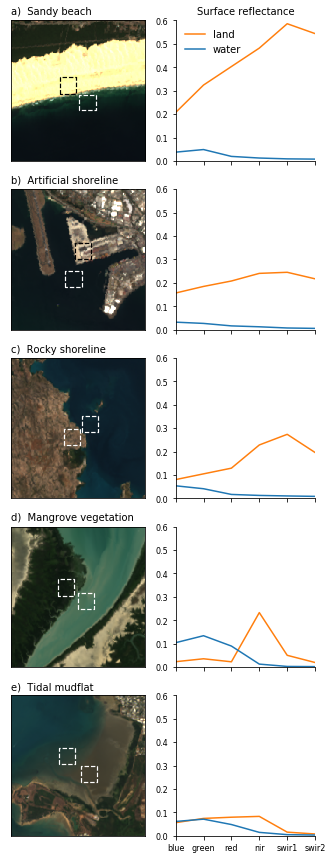

In [470]:
from datacube.utils import geometry
from datacube.utils.geometry import CRS
import matplotlib.pyplot as plt
from cycler import cycler

# Change line colour plotting order (hack to make water blue)
plt.rc('axes', prop_cycle=(cycler('color', ['#ff7f0e', '#1f77b4']) +
                           cycler('linestyle', ['-', '-'])))

# Set up plot subplots plotting locations and annotations
env_ann = {'sandybeach': 'a)  Sandy beach', 
           'artificial': 'b)  Artificial shoreline', 
           'rocky': 'c)  Rocky shoreline', 
           'mangroveveg': 'd)  Mangrove vegetation', 
           'tidalflat': 'e)  Tidal mudflat'}
env_loc = {'sandybeach': 0, 'artificial': 2, 'rocky': 4, 'mangroveveg': 6, 'tidalflat': 8}

# Read in spectra
output_spectra = pd.read_csv('spectra_outputs/output_spectra.csv', index_col='spectra')
output_spectra.index = output_spectra.index.str.split('_',expand=True)
output_spectra['scaling'] = (output_spectra.lat/-12.29405)**0.15
output_spectra['poly_col'] = ['black'] + 3 * ['white'] + ['black'] + 5 * ['white']

# Innitiate plot
fig, axes = plt.subplots(5, 2, figsize=(5.5, 15)) #, gridspec_kw={'width_ratios': [1.0, 0.8]})

for (spectra_env, spectra_type), spectra_data in output_spectra.iterrows():
    
    if spectra_type == 'land':
        
        x, y = geometry.point(spectra_data.lon, spectra_data.lat, CRS('WGS84')).to_crs(CRS('EPSG:3857')).points[0]
    
        # Set up query
        extent_scale = 2000  * spectra_data.scaling
        query = dict(time=spectra_data.date,
                     lat=(y - extent_scale, y + extent_scale), 
                     lon=(x - extent_scale + 100, x + extent_scale - 100))

        # Load data
        ds = dc.load(product='ls8_nbart_albers',
                     measurements=['blue', 'green', 'red', 'nir', 'swir1', 'swir2'],
                     crs='EPSG:3857',
                     output_crs='EPSG:3857', 
                     group_by='solar_day',
                     resolution=(-25, 25),
                     resampling='cubic',
                     **query)        

        rgb_array = np.transpose(ds[['red', 'green', 'blue']].squeeze().to_array().values, axes=[1, 2, 0])
        
        env_ax = axes.flat[env_loc[spectra_env]]
        spectra_ax = axes.flat[env_loc[spectra_env] + 1]
        env_ax.imshow(rgb_array / 3000, extent=[ds.x.min().item(), ds.x.max().item(),
                                                ds.y.min().item(), ds.y.max().item()])
        land_shape = gpd.read_file(f'spectra_outputs/{spectra_env}_land.json').to_crs({'init': str(ds.crs)})
        water_shape = gpd.read_file(f'spectra_outputs/{spectra_env}_water.json').to_crs({'init': str(ds.crs)})
        land_shape.plot(ax=env_ax, facecolor='none', edgecolor=spectra_data.poly_col, linewidth=1.2, linestyle='--')
        water_shape.plot(ax=env_ax, facecolor='none', edgecolor='white', linewidth=1.2, linestyle='--')
        env_ax.set_title(env_ann[spectra_env], loc="left", fontsize=10)
        
        env_ax.get_xaxis().set_visible(False)
        env_ax.get_yaxis().set_visible(False)
        spectra_ax.tick_params(axis='x', labelsize=8)
        spectra_ax.tick_params(axis='y', labelsize=8)
        
    (spectra_data.iloc[3:-2] / 10000).plot(ax=spectra_ax)
    spectra_ax.set_ylim(0, 0.6)
    spectra_ax.spines['right'].set_visible(False)
    spectra_ax.spines['top'].set_visible(False)
    spectra_ax.yaxis.set_ticks_position('left')
    spectra_ax.xaxis.set_ticks_position('bottom')  
    
    if (env_loc[spectra_env] + 1) < 9:
        spectra_ax.xaxis.set_ticklabels([])

axes.flat[1].set_title('Surface reflectance', fontsize=10)
l=axes.flat[1].legend(loc='upper left', labels=['land', 'water'], prop=dict(size=10), frameon=False)
plt.savefig('figures/paper/spectra_casestudies.png', dpi=300, bbox_inches='tight')   